In [ ]:
import pyart
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import datetime
import pandas as pd
import xarray as xr

In [ ]:
path_data = '/content/drive/MyDrive/dados/radar' # local dos dados radar (banda-x ou banda-s) neste Colab
srads = path_data + 'banda-s/' # dados do radar banda-s 
xrads = path_data + 'banda-x/' # dados do radar banda-x

In [ ]:
# nesta parte é para pôr todos os arquivos em um "pandas dataframe" com as datas; 
# assim fica mais fácil acessar o arquivo que se deseja ler/ver.

paths_s = []
dates_s = []
for root, dirs, files in os.walk(srads):
    for name in files:
        fpath = os.path.join(root, name)
        if fpath[-4:] == 'tore':
            break
        date = datetime.datetime.strptime(name[3:15], '%y%m%d%H%M%S')
        paths_s.append(fpath)
        dates_s.append(date)
files_s = pd.DataFrame.from_dict({'paths': paths_s,
                               'time': dates_s})

files_s = files_s.sort_values('time')
files_s = files_s.set_index('time')


## Como acessar os dados em um dataframe

Na célula a baixo, vocês podem ver o que é um dataframe. Nele temos o dataframe mais básico: só tem uma coluna e um índice. O índice é o tempo e os elementos dele são objetos "datetime.datetime", um objeto do python para ter datas 

In [ ]:
files_s

,paths
time,
2020-02-01 00:03:50,/content/radar/raws/banda-s/2020/02/01/XXX2002...
2020-02-01 00:12:43,/content/radar/raws/banda-s/2020/02/01/XXX2002...
2020-02-01 00:21:35,/content/radar/raws/banda-s/2020/02/01/XXX2002...
2020-02-01 00:30:29,/content/radar/raws/banda-s/2020/02/01/XXX2002...
2020-02-01 00:39:24,/content/radar/raws/banda-s/2020/02/01/XXX2002...
...,...
2020-02-01 23:20:22,/content/radar/raws/banda-s/2020/02/01/XXX2002...
2020-02-01 23:29:20,/content/radar/raws/banda-s/2020/02/01/XXX2002...
2020-02-01 23:38:15,/content/radar/raws/banda-s/2020/02/01/XXX2002...


### As funções loc e iloc

Estas duas funções são a maneira de acessar o dataframe; não são realmente funções, mas métodos do objeto 'pandas.dataframe'
O método `loc[]` é para assessar o dataframe por nomes: por exemplo, se quisermos a localisaçao do arquivo de 01 de Fevereiro de 2020 às 23 horas 20 minutos e 22 segundos do radar-s, podemos fazer o seguinte:

`filepath = files_s.loc[datetime.datetime(2020, 2, 1, 23, 20, 22), :]`

In [ ]:
filepath = files_s.loc[datetime.datetime(2020, 2, 1, 23, 20, 22), :]
print('filepath :', filepath)

filepath : paths    /content/radar/raws/banda-s/2020/02/01/XXX2002...
Name: 2020-02-01 23:20:22, dtype: object


Não entrarei com mais detalhes, para que vocês façam um pouco de data science; eu faria uma recomendação para fazerem um cursinho rapidinho de pandas: é um package muito bom e muito utilizado 

# Como ler um file radar com pyart

Agora mostrarei para vocês como é que se faz para ler os dados da funceme com a biblioteca (package) pyart: ele é um package muito bom, feito pelo pessoal dos Estados Unidos, acho, mas nao tenho certeza.

A gente tem que começar pelo localisação do arquivo. Nós vamos usar um método de acesso para os dataframes que não vimos aqui, mas acho que fala por si só. 

`filepath = files_s.paths.iloc[0]`

Depois, vamos usar a função do `pyart` que é `pyart.io.read()`: o que ela faz é criar um objeto `radar` do pyart, objeto que o packege usa para fazer tudo o que ele pode

In [ ]:
filepath_s = files_s.paths.iloc[0]
radar_s = pyart.io.read(filepath_s)

print('Type of "radar" object :', type(radar_s))

Type of "radar" object : <class 'pyart.core.radar.Radar'>


In [ ]:
filepath_s

'/content/radar/raws/banda-s/2020/02/01/XXX200201000350.RAWDL5R'

### Investigação dos arquivos radar

O package `pyart` tem um método muito bom para os objetos `Radar`, que é o método `info()`. Podemos chamar essa função/método com as strings (argumentos) `'compact'`, dentre outros. `info()` é um método para ter uma ideia do que o radar tem

In [ ]:
radar_s.info('full')

altitude:
	data: [800.]
	long_name: Altitude
	standard_name: Altitude
	units: meters
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: [  0.41198727   1.3375853    2.3703     ... 357.32758    358.33008
 359.34906   ]
	units: degrees
	standard_name: beam_azimuth_angle
	long_name: azimuth_angle_from_true_north
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: [-0.7910078 -0.7910078 -0.7910078 ...  8.481445   8.481445   8.481445 ]
	units: degrees
	standard_name: beam_elevation_angle
	long_name: elevation_angle_from_horizontal_plane
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
total_power:
		data: [[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]
		units: dBZ
		standard_name: equivalent_reflectivity_factor
		long_name: Total power
		coordinates: ele

## Funções que eu fiz para usar o `pyart` com `xarray`: `get_grid` e `get_xarray`

Pyart é muito bom, mas eu gosto muito do `xarray` para fazer estatísticas, cálculos e outras coisas. Então, eu criei duas funções para ter as informaçẽes que eu desejo em um `dataset` do `xarray`. Não explicarei muito como fazer coisas com o `xarray`, só como usar as funções para fazer os datasets. Vocês podem encontrar explicações muito melhores do que poderia fazer em cursos online 

In [ ]:
def get_grid(radar, field='reflectivity', volumetric=False):
    gatefilter = pyart.filters.GateFilter(radar)
    gatefilter.exclude_transition()
    npoints = 2 * radar.ngates
    max_coord = radar.range['data'][-1]
    min_coord = - max_coord
    if volumetric:
        max_angle = radar.elevation['data'].max()*np.pi/180
        min_angle = radar.elevation['data'].min()*np.pi/180
        max_height = np.sin(max_angle)*max_coord
        min_height = np.sin(min_angle)*max_coord
        lims_z = (min_height, max_height)
        zpoints = radar.nsweeps*2
    else : 
        lims_z = (-100, 100)
        zpoints = 1
    grid_shape = (zpoints, npoints, npoints)
    lims_xy = (min_coord, max_coord)
    grid = pyart.map.grid_from_radars((radar,),
                                     gatefilters=gatefilter,
                                     grid_shape=grid_shape,
                                     grid_limits=(lims_z, lims_xy, lims_xy),
                                     fields=[field],
                                     weighting_function='Barnes2')
    return grid


def get_xarray(df_filepaths, **kwargs):
    list_paths = df_filepaths.paths.tolist()
    xarrays = []
    for path in list_paths:
        radar = pyart.io.read(path)
        grid = get_grid(radar, **kwargs)
        xarr = grid.to_xarray()
        xarrays.append(xarr)
    big_xr = xr.concat(xarrays, dim='time')
    return big_xr

grid_s = get_grid(radar_s, volumetric = False)

In [ ]:
radar_s_xarray = grid_s.to_xarray()
radar_s_xarray

<xarray.Dataset>
Dimensions:       (time: 1, x: 506, y: 506, z: 1)
Coordinates:
  * time          (time) object 2020-02-01 00:04:15
  * z             (z) float64 -100.0
    lat           (y) float64 -8.462 -8.449 -8.435 ... -1.685 -1.672 -1.658
    lon           (x) float64 -42.71 -42.69 -42.68 ... -35.86 -35.84 -35.83
  * y             (y) float64 -3.785e+05 -3.77e+05 ... 3.77e+05 3.785e+05
  * x             (x) float64 -3.785e+05 -3.77e+05 ... 3.77e+05 3.785e+05
Data variables:
    reflectivity  (time, z, y, x) float32 nan nan nan nan ... nan nan nan nan
    ROI           (time, z, y, x) float32 1.401e+04 1.398e+04 ... 1.401e+04

### Maneiras fáceis de plotar com xarray e cartopy

Como vocês podem ver acima, o xarray dataset tem duas variáveis: uma é a que queremos, a reflectividade. Para acessar somente essa variável temos que pôr simplemente um ponto e o seu nome depois, assim : `radar_xarray.reflectivty`

Depois, podemos visualizar diretamente com o método plot(); uma coisa boa é que vocês podem plotar com as coordenadas que quiserem; para que elas sejam em km ou em graus, escolhemos por meio dos argumentos `x` e `y`. Tenho uns exemplos abaixo

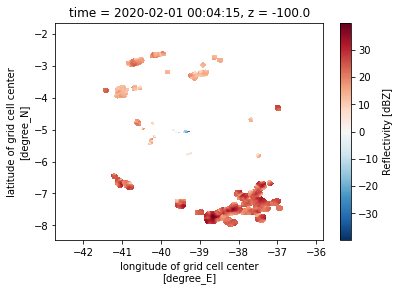

In [ ]:
radar_s_xarray.reflectivity.plot(x='lon', y='lat')

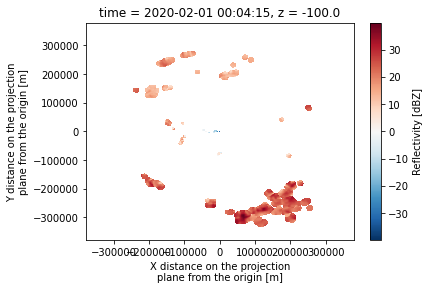

In [ ]:
radar_s_xarray.reflectivity.plot(x='x', y='y')

#### Usar o cartopy 

O pacote `cartopy` é um bom módulo do python para fazer visualizações de mapas; não entrarei em detalhes mas vocês podem ver como é que se usa no exemplo abaixo

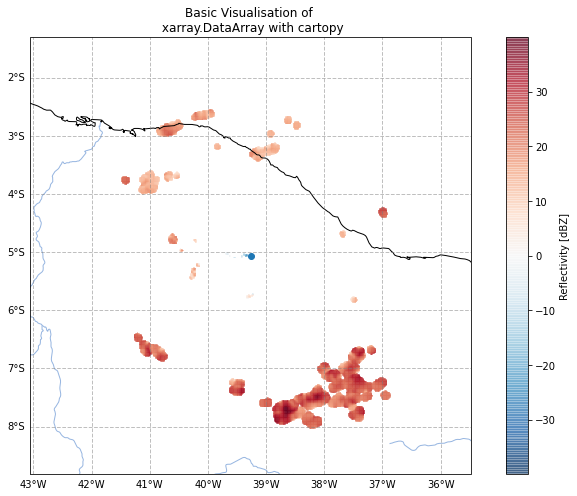

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, aspect='equal', projection=ccrs.PlateCarree()) # visualization parameters
radar_s_xarray.reflectivity.plot(ax=ax, alpha=0.5, x='lon', y='lat') # xarray method for plotting, we have to pass the ax argument

# Cartopy features for geographical things to be plotted
ax.add_feature(cfeature.BORDERS) 
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)

# plotting the center of the radar
ax.scatter(-39.267040, -5.069224)

#adding gridlines to map
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False


ax.set_title('Basic Visualisation of \n xarray.DataArray with cartopy')

plt.tight_layout()

#### Exemplo de tudo feito: um atrás do outro

Aqui vocês podem ver como fazer tudo com um arquivo aleatório

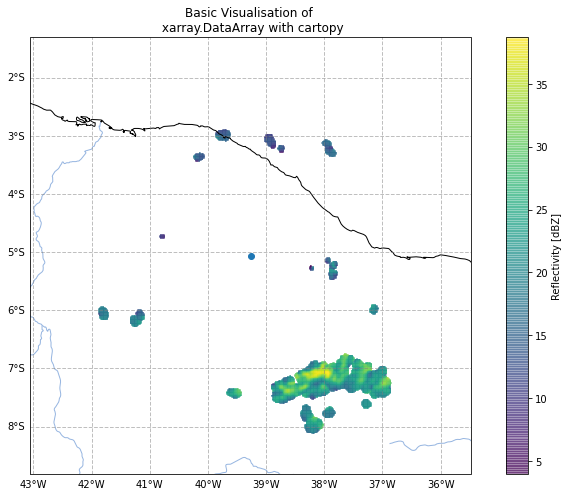

In [ ]:
radar_filepath = files_s.loc[:,'paths'].tolist()[13]
radar_pyart = pyart.io.read(radar_filepath)
radar_grid = get_grid(radar_pyart)
radar_xarrayx = radar_grid.to_xarray()

lon0 = radar_pyart.longitude['data']
lat0 = radar_pyart.latitude['data']

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, aspect='equal', projection=ccrs.PlateCarree()) # paramères de la visualisation
radar_xarrayx.reflectivity.plot(ax=ax, alpha=0.5, x='lon', y='lat') # méthode des xarray.DataArrays pour plotter, comme tu peux voir, c'est assez simple

# Cartopy features for geographical things to be plotted
ax.add_feature(cfeature.BORDERS) 
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)

ax.scatter(lon0, lat0)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False


ax.set_title('Basic Visualisation of \n xarray.DataArray with cartopy')

plt.tight_layout()